The Auto-Regressive (AR) process is a time series model where each value in the series is predicted based on its past values. In an AR model of order  𝑝
  noted as  AR(𝑝)
 , the current value depends on a linear combination of the previous  𝑝
  values. Formally, we can write:

The Moving Average (MA) process is a time series model where each value in the series is defined by a combination of random errors from previous periods

In an MA model, the random errors  𝜖𝑡
  are not calculated directly, they represent the residuals observed at each point in the time series. Unlike classical predictive models, MA model values are not based on predictions in the sense of estimating future values of the series. Instead, the model is built using past errors to explain the structure of the series.

To estimate these errors in an MA model, we typically use an observed data series and apply fitting methods, such as the least squares method, to estimate the coefficients  𝛽𝑖
  that minimize the difference between the model and the actual data. Once the coefficients are estimated, past errors can be calculated based on the residuals (differences between observed values and values predicted by the model).

Thus, random errors are more a way of modeling irregularities and are not explicitly "predictive".

In [10]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

df = pd.read_csv(os.path.join(path, os.listdir(path)[0]), header=0, index_col=0, parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


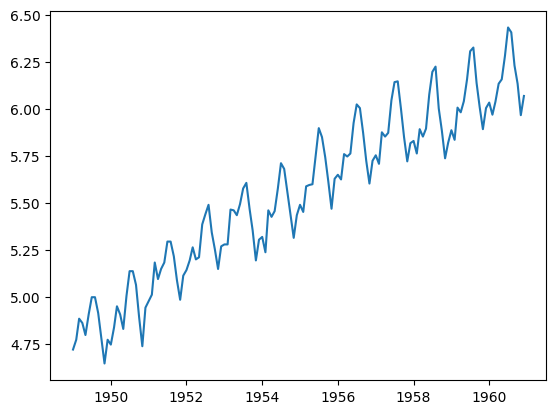

In [3]:
airpasslog = np.log(df)
plt.plot(airpasslog)

While the logarithmic transformation yields a seasonal variation with almost constant amplitude, we notice that our time series shows a strong trend.

Thus our series is not stationary. One of the limitations of the  ARMA
  model is that it can only model stationary processes.

Mathematically, we define the stationarity of a time series ( 𝑋𝑡
 ) (in the weak sense) as:

(1) A constant mean or expectation  𝔼(𝑋𝑡)=𝜇
 
(2) A constant and finite variance  𝑉𝑎𝑟(𝑋𝑡)=𝜎2<∞
 
(3) The autocorrelation between variable  𝑋𝑡
  and variable  𝑋𝑡−𝑘
  depends only on the lag k, and is equal regardless of  𝑡
 .




Therefore, to model our time series, we will try to make it stationary.

For this, we proceed by differencing, meaning we will work with differences between the values of our time series.

To visualize this transformation, let's take an example:

Imagine a series  𝑋𝑡
  having a linear trend, so we have  𝑋𝑡=𝛼𝑡+𝜖𝑡
 .

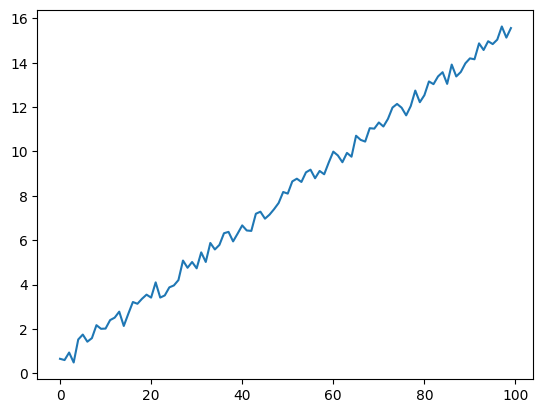

In [4]:
epsilon = np.random.rand(100) #White Noise
t = np.linspace(0,10,100) # Time
alpha = 1.5 #trend coefficient
total = pd.DataFrame(alpha * t + epsilon)
plt.plot(total)

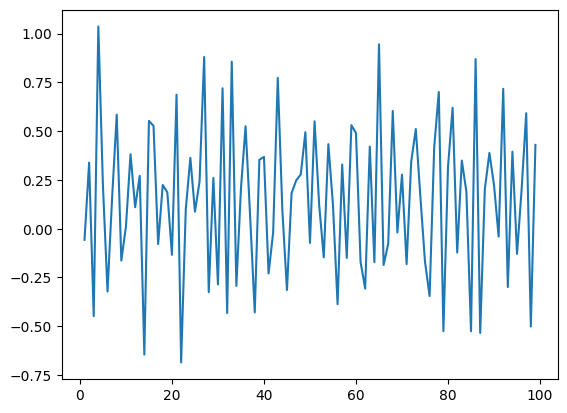

In [5]:
total_diff = total.diff().dropna() #differenciation
plt.plot(total_diff);

To visualize if a series is stationary, we can look at its autocorrelation diagram ( 3𝑟𝑑
  property of stationarity), but we should also look directly at the transformed series to see if there is still a trend or seasonality.

The autocorrelation of a time series corresponds to the correlation between time t and time t-h. The autocorrelation function  𝜌(ℎ)
  therefore corresponds to the correlation of the series with itself.

𝜌(ℎ)=Corr(𝑋𝑡,𝑋𝑡−ℎ)
 

We can therefore see autocorrelation as the square root of the  𝑅2
  of the linear regression between  𝑋𝑡
  and  𝑋𝑡−ℎ
 .

n addition to this notion, we also define the partial autocorrelation of a time series  𝑟(ℎ)
  as the correlation between time  𝑡
  and time  𝑡−ℎ
  without taking into account the contribution of intermediate times.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

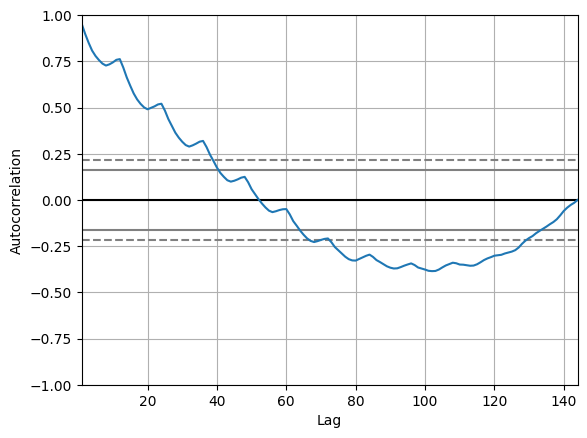

In [6]:
pd.plotting.autocorrelation_plot(airpasslog)

We observe that the decrease in the autocorrelation function is relatively slow. Therefore, we apply a first-order differencing to our time series to see if this helps make it stationary.

To difference a time series, we can use the diff method from pandas. It takes as an argument the order of differencing, which is the gap between the two values to be differenced.



<Axes: xlabel='Lag', ylabel='Autocorrelation'>

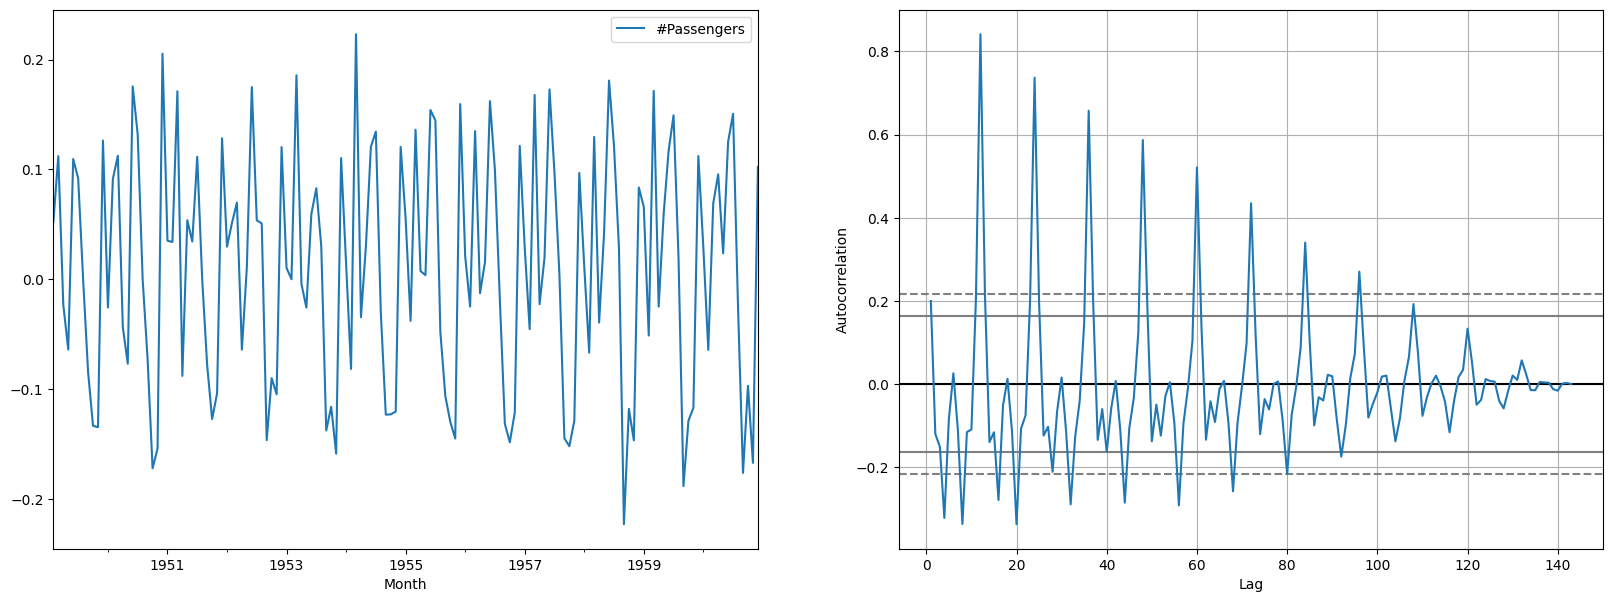

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Creating figure and axes

airpasslog_1 = airpasslog.diff().dropna() # First order differencing

airpasslog_1.plot(ax = ax1) # Differenced time series

pd.plotting.autocorrelation_plot(airpasslog_1, ax = ax2)

The simple autocorrelation seems to tend towards 0 but shows significant seasonal peaks (We can also see these seasonal patterns directly in the series graph). We will therefore difference the time series to eliminate the seasonality preventing stationarity (not yet a rapid decrease to zero).

As we could intuitively expect, the time series seems to show a seasonality of period 12: air traffic is higher in summer than in winter due to summer holidays.

Using the periods parameter of the diff method allows us to difference a time series to deseasonalize it according to a period.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

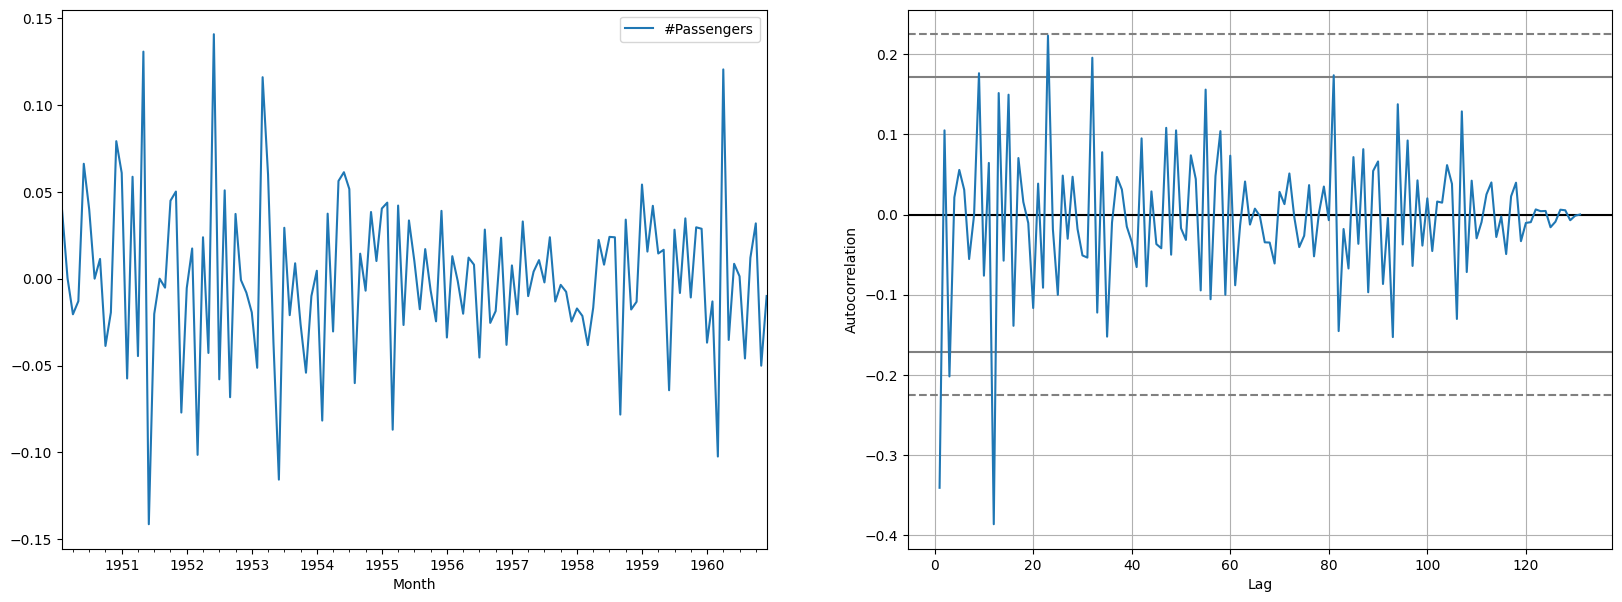

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Creating figure and axes

airpasslog_2 = airpasslog_1.diff(periods = 12).dropna() # Differencing of order 12

airpasslog_2.plot(ax = ax1) # Twice-differenced series

pd.plotting.autocorrelation_plot(airpasslog_2, ax = ax2)

We arrive here at a fairly satisfactory result despite a few irregular peaks. We can say that the values decrease quickly enough for us to consider the process as probably stationary. Moreover, the twice-differenced series no longer seems to show either a trend or seasonality.

The differencing process is done iteratively, and requires trial and error and analysis of the outputs we obtain. To ensure the stationarity of the differenced series, it is necessary to perform a statistical test. There are several, we will use the most common one, the Augmented Dickey-Fuller test (ADF).

For a p-value less than 5%, we can reject the hypothesis that the series is not stationary and therefore consider it as stationary.

The ADF test is implemented in the statsmodels library through the adfuller function from the tsa.stattools submodule which takes the Series to be tested as an argument. The second value returned by the function corresponds to the p-value of the test.

In [11]:
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(airpasslog_2)
print(p_value)

0.0002485912311384052
